## Import Google Drive Here

In [0]:
import torch

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import modules

In [0]:
import os
import pickle

from os.path import isdir, join
from pathlib import Path

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Check googld drive is mounted

In [0]:
!ls "/content/drive/My Drive/ASR/"

 ASA2019NonNativeSpeech_edSP_JC.pptx   list1.csv
 ASA2019NonNativeSpeech_edSP.pptx      meeting03112019.txt
 ASA2019NonNativeSpeech.pptx	       Participants_List_SeongjinPark.xlsx
 bin				       Participants_List.xlsx
 experiment			       pic
'~$LabMeeting20181129.pptx'	       reading.xlsx
 LabMeeting20181129.pptx	       recordings
 letter_SeongjinPark.docx	       result


## Check the directory of WAV files

In [0]:
audio_path = '/content/drive/My Drive/ASR/recordings/extract/wavs/'
print(os.listdir(audio_path)[:10])

['S25_How-Permanent-Are.wav', 'S05_Pam-Gives-Driving.wav', 'S09_Gently-Place-Jims.wav', 'S02_He-Ate-Four.wav', 'S24_Ralph-Prepared-Red.wav', 'S09_The-Surplus-Shoes.wav', 'S02_The-Tooth-Fairy.wav', 'S04_They-All-Like.wav', 'S19_Any-Organism-That.wav', 'S25_Gregory-And-Tom.wav']


In [0]:
wav2idx = {}
melspec_dict = {}
mfcc_dict = {}
wav_names = [wav for wav in os.listdir(audio_path) if wav.endswith("wav")]

samples = 132300
max_len = 0

for i, w in enumerate(wav_names):
    wav2idx[w] = i
    wav_path = audio_path + w
    
    y, sr = librosa.load(wav_path) 
    
#     sample = sr * 5
    
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)

    if len(y) > samples: # long enough
        y = y[0:0+samples]

    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    
    
    mel_data = librosa.feature.melspectrogram(y = y, sr= sr)
    mfcc_data = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13)
    mfcc_delta = librosa.feature.delta(mfcc_data)
    mfcc_delta2 = librosa.feature.delta(mfcc_data, order = 2)

    mfcc = np.vstack((mfcc_data, mfcc_delta, mfcc_delta2))
#     if (np.shape(mel_data)[1] > max_len):
#         max_len = np.shape(mel_data)[1] 
    
    melspec_dict[i] = mel_data
    mfcc_dict[i] = mfcc

In [0]:
print(max_len)
print(sr * 5)
for i in list(melspec_dict.keys())[:10]:
    print(melspec_dict[i].shape)


0
110250
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)


In [0]:
with open("/content/drive/My Drive/ASR/result/fluency_data.csv", "r") as f:
    data = f.readlines()

In [0]:
X = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = mfcc_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))

(11100, 39, 259)
(11100,)


In [0]:
Y_onehot = to_categorical(Y)
print(np.shape(X))
print(np.shape(Y_onehot))

(11100, 39, 259)
(11100, 6)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.3, random_state=42)

In [0]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_classes = np.shape(Y_onehot)[1]
num_mel = np.shape(X)[1]
max_time = np.shape(X)[2]



In [0]:
# reshape
input_shape = (num_mel, max_time, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], num_mel, max_time, 1)
X_test = X_test.reshape(X_test.shape[0], num_mel, max_time, 1)
print(np.shape(X_train))
print(np.shape(X_test))

(7770, 39, 259, 1)
(3330, 39, 259, 1)


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(np.shape(y_train), np.shape(y_test))

X_train shape:  (7770, 39, 259, 1)
7770 train samples
3330 test samples
(7770, 6) (3330, 6)


In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(drop_out_rate))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(drop_out_rate))
model.add(Conv2D(16, kernel_size = (2, 2), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(drop_out_rate))
# model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(drop_out_rate))
# model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(drop_out_rate))
model.add(Flatten())

model.add(Dense(num_dense_unit, activation = 'relu'))
model.add(Dropout(drop_out_rate))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(drop_out_rate))

model.add(Dense(num_classes, activation = 'softmax'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 37, 257, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 128, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 128, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 126, 32)       18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 63, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 63, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 62, 16)        

In [0]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [0]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = 50, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_test, y_test), callbacks=[tensorboard_callback])

model.save('/content/drive/My Drive/ASR/result/CNN_fluency_model_50_deltas.h5')

Train on 7770 samples, validate on 3330 samples
Epoch 1/50
2048/7770 [======>.......................] - ETA: 1:28 - loss: 1.2649 - acc: 0.4731

KeyboardInterrupt: ignored

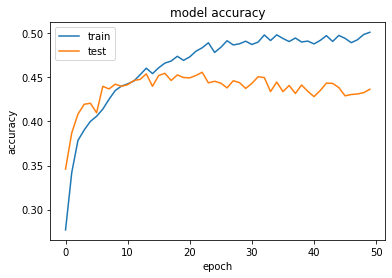

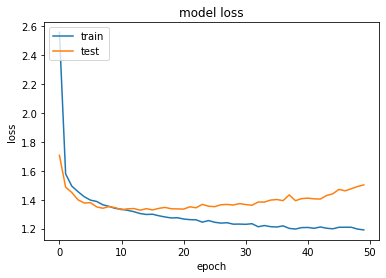

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = keras.models.load_model('/content/drive/My Drive/ASR/result/CNN_fluency_model_50_deltas.h5')

In [0]:
y_predictions = model.predict(X_test)

In [0]:
y_true = np.argmax(y_test, axis = -1)
y_pred = np.argmax(y_predictions, axis = -1)

In [0]:
count = 0

for i in range(len(y_pred)):
  if y_true[i] == y_pred[i]:
    count += 1

print(count/len(y_true))

0.43663663663663665


In [0]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#
def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.

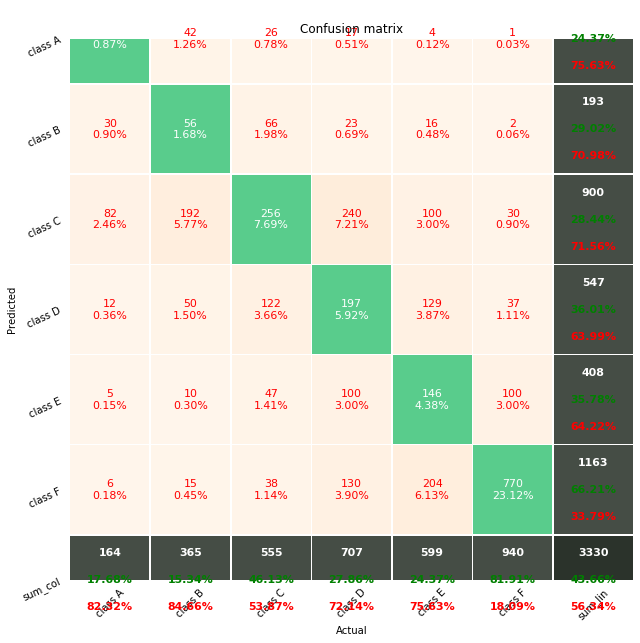

In [0]:
plot_confusion_matrix_from_data(y_true, y_pred, columns = [], annot = True, cmap = "Oranges")

In [0]:
# reshape
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_train))
print(np.shape(X_test))
y_train = y_train.reshape(y_train.shape[0], num_classes, 1)
y_test = y_test.reshape(y_test.shape[0], num_classes, 1)
print(np.shape(y_train), np.shape(y_test))
# input_shape = (num_mel, max_time, 1)


# print(np.shape(X_train))
# print(np.shape(X_test))

(7564, 259, 39, 1)
(3242, 259, 39, 1)
(7564, 6, 1) (3242, 6, 1)


In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_swzya6s
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_swzya6s
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=a5e925aaf0c7eb15fb1a7e193ae96d461a5761557c0538a83af117fe64d79f73
  Stored in directory: /tmp/pip-ephem-wheel-cache-8s480prb/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras_contrib.layers import CRF
from keras.layers import Bidirectional, TimeDistributed
from keras.models import Model, Input

# input_shape = (num_mel, max_time)


# model = Sequential()

# model.add(GRU(512, input_shape = input_shape))
# model.add(Dropout(drop_out_rate))
# model.add(Dense(num_dense_unit * 2, activation = 'relu'))
# model.add(Dense(num_dense_unit, activation='relu'))
# model.add(CRF())

# # use adam optimizer
# adam = keras.optimizers.Adam(lr = lr)

# # compile the model
# model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

# model.summary()

input = Input(shape=(max_time, num_mel))

model = Bidirectional(LSTM(units=50, return_sequences=False, recurrent_dropout=0.1))(input)  # variational biLSTM
model = Dense(num_dense_unit, activation="relu")(model)  # a dense layer as suggested by neuralNer
crf = CRF(units = num_classes)  # CRF layer
out = crf(model)  # output

ValueError: ignored

In [0]:
model = Model(input, out)

In [0]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [0]:
model.summary()

In [0]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_test, y_test), callbacks=[tensorboard_callback])

model.save('/content/drive/My Drive/ASR/result/RNN_model_deltas_fluency_50.h5')
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7564 samples, validate on 3242 samples
Epoch 1/50
7564/7564 [==============================] - 13s 2ms/step - loss: 1.6030 - acc: 0.3817 - val_loss: 1.4400 - val_acc: 0.4244
Epoch 2/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.4005 - acc: 0.4483 - val_loss: 1.4275 - val_acc: 0.4337
Epoch 3/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.3542 - acc: 0.4622 - val_loss: 1.4293 - val_acc: 0.4426
Epoch 4/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.3256 - acc: 0.4664 - val_loss: 1.4158 - val_acc: 0.4436
Epoch 5/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.3034 - acc: 0.4800 - val_loss: 1.4111 - val_acc: 0.4417
Epoch 6/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.2871 - acc: 0.4828 - val_loss: 1.3997 - val_acc: 0.4411
Epoch 7/50
7564/7564 [==============================] - 12s 2ms/step - loss: 1.2717 - acc: 0.4828 - val_loss: 1.4086 - val_acc: 0.4439
Epoch 8

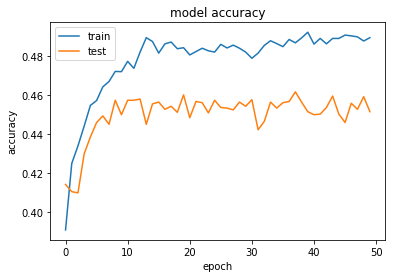

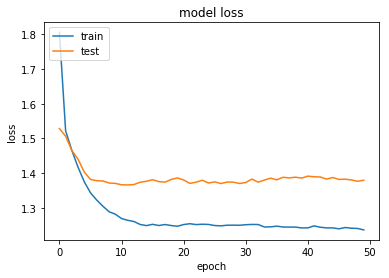

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
input_shape = (num_mel, max_time)

model = Sequential()

model.add(GRU(512, input_shape = input_shape))
model.add(Dropout(drop_out_rate))
model.add(Dense(num_dense_unit))
model.add(Dense(num_classes, activation='softmax'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 512)               1185792   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 1,318,662
Trainable params: 1,318,662
Non-trainable params: 0
_________________________________________________________________


In [0]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
num_epochs = 400
model.load_weights('/content/drive/My Drive/ASR/result/RNN_model_200.h5')

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_test, y_test), callbacks=[tensorboard_callback])

model.save('/content/drive/My Drive/ASR/result/RNN_model_400.h5')
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7564 samples, validate on 3242 samples
Epoch 1/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2014 - acc: 0.5164 - val_loss: 1.4275 - val_acc: 0.4605
Epoch 2/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2003 - acc: 0.5144 - val_loss: 1.4425 - val_acc: 0.4547
Epoch 3/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2111 - acc: 0.5107 - val_loss: 1.4115 - val_acc: 0.4525
Epoch 4/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2118 - acc: 0.5128 - val_loss: 1.4349 - val_acc: 0.4426
Epoch 5/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2110 - acc: 0.5118 - val_loss: 1.4384 - val_acc: 0.4457
Epoch 6/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2211 - acc: 0.5085 - val_loss: 1.3750 - val_acc: 0.4608
Epoch 7/400
7564/7564 [==============================] - 22s 3ms/step - loss: 1.2209 - acc: 0.5032 - val_loss: 1.4093 - val_acc: 0.4411


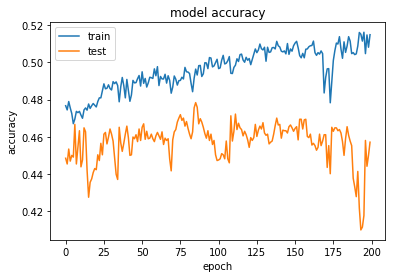

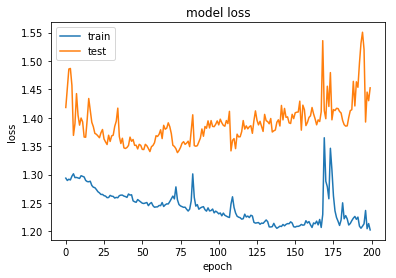

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()